<a href="https://colab.research.google.com/github/benchov/Machine_Learning_for_Trading_Knowledge/blob/main/XGB_Feature_Selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [30]:
# Installs

In [31]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category="FutureWarning")

# General
import numpy as np

# Data management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

# Evaluation 
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

In [32]:
# Import preprocessed data
df = pd.read_csv('/content/BTC-USD.csv')
df.set_index('Date', inplace=True)
df.head()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,MA_12,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-31,0.000878,0.053054,0.001615,970.403015,1.103895,0.054348,0.055442,-0.029463,60.205366,1.192634,918.828003,885.613522,1,0.011408,0.057910,0.000964,0.003887,1.003974,-0.002272,0.004646,0.991144
2017-02-01,0.054272,0.017587,0.054056,989.023010,-0.087932,0.019188,0.018926,-0.009863,63.109498,1.048237,926.661087,895.673808,2,0.007132,0.057381,0.054348,0.055442,1.192634,0.000964,0.003887,1.003974
2017-02-02,0.019630,0.024675,0.012855,1011.799988,-0.028572,0.023030,0.030816,0.012600,66.345006,1.051268,934.162003,905.529332,3,0.008542,0.057675,0.019188,0.018926,1.048237,0.054348,0.055442,1.192634
2017-02-03,0.021676,0.020079,0.026005,1029.910034,0.380309,0.017899,0.024861,0.032145,68.695922,1.035435,942.931758,915.335333,4,-0.079792,0.054832,0.023030,0.030816,1.051268,0.019188,0.018926,1.048237
2017-02-04,0.019645,0.011636,0.006314,1042.900024,-0.229603,0.012613,0.030281,0.045785,70.298572,1.023330,953.089091,926.025239,5,0.055230,0.045565,0.017899,0.024861,1.035435,0.023030,0.030816,1.051268


In [33]:
# add prediction target
df.loc[df['Range'].shift(-1) > df['Avg_Range'], 'TARGET'] = 1
df.loc[df['Range'].shift(-1) < df['Avg_Range'], 'TARGET'] = 0

In [34]:
# fill NA's
df['TARGET'].fillna(0, inplace=True)
df.tail()

,Open,High,Low,Close,Volume,Returns,Range,Bench_C_Rets,RSI,RSI_Ret,MA_12,MA_21,DOW,Roll_Rets,Avg_Range,Returns_T1,Range_T1,RSI_Ret_T1,Returns_T2,Range_T2,RSI_Ret_T2,TARGET
Date,,,,,,,,,,,,,,,,,,,,,,
2022-05-28,-0.021487,-0.018129,0.008047,28814.900391,-0.029042,0.006544,0.009117,32.894788,37.238957,1.027560,29453.642415,29874.254371,5,-0.298233,0.056286,-0.021856,0.036020,0.949541,-0.009984,0.055632,0.977232,0.0
2022-05-29,0.013879,0.023707,0.010035,29445.957031,-0.490594,0.021900,0.022777,33.634047,40.613855,1.090628,29371.984049,29654.573010,6,-0.247068,0.055605,0.006544,0.009117,1.027560,-0.021856,0.036020,0.949541,1.0
2022-05-30,0.014593,0.083111,0.016035,31726.390625,1.170788,0.077445,0.090298,36.313300,50.890862,1.253042,29622.493978,29722.641462,0,-0.146443,0.057666,0.021900,0.022777,1.090628,0.006544,0.009117,1.027560,0.0
2022-05-31,0.077454,0.009397,0.067657,31792.310547,-0.146132,0.002078,0.030803,36.391116,51.154006,1.005171,29745.658691,29759.279762,1,-0.164364,0.057768,0.077445,0.090298,1.253042,0.021900,0.022777,1.090628,1.0
2022-06-01,0.002165,-0.009072,-0.057040,29799.080078,0.226536,-0.062695,0.083239,34.041939,43.554422,0.851437,29795.520345,29800.361886,2,-0.228625,0.059741,0.002078,0.030803,1.005171,0.077445,0.090298,1.253042,0.0


In [35]:
# create train test split
df_tts = df.copy()
X = df_tts.drop('TARGET', axis=1)
y = df_tts["TARGET"]
X.shape, y.shape

((1948, 21), (1948,))

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=883)

In [37]:
# build first classifier model - baseline model
clf_0 = XGBClassifier(
    objective="binary:logistic",
    booster="gbtree",
    eval_metric="logloss",
    subsample=0.8,
    colsample_bytree=1,
    random_state=883,
    use_label_encoder=False
)

In [38]:
# find hyperparameters
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 6, 12, 20],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    "max_depth": [1, 2, 3, 4, 5, 6, 8, 12],
    "n_estimators": [25, 50, 65, 80, 100, 115, 200]
}

In [39]:
# perform random search to find best params
grid_search = RandomizedSearchCV(
  estimator=clf_0, 
  param_distributions=param_grid, 
  scoring="precision"
  )
best_model = grid_search.fit(X_train, y_train)
hyperparams = best_model.best_params_
hyperparams

{'n_estimators': 115, 'max_depth': 1, 'learning_rate': 0.1, 'gamma': 12}

In [40]:
# build model_1 based on the calulated optimal params
clf_1 = XGBClassifier(
    objective="binary:logistic",
    booster="gbtree",
    eval_metric="logloss",
    subsample=0.8,
    colsample_bytree=1,
    random_state=883,
    use_label_encoder=False,
    n_estimators=hyperparams["n_estimators"],
    learning_rate=hyperparams["learning_rate"],
    max_depth=hyperparams["max_depth"],
    gamma=hyperparams["gamma"]
)

In [42]:
# fit model
clf_1.fit(
    X_train,
    y_train,
    eval_metric=['error', 'logloss'],
    eval_set=[(X_train, y_train)],
    verbose=False
)

XGBClassifier(eval_metric='logloss', gamma=12, max_depth=1, n_estimators=115,
              random_state=883, subsample=0.8, use_label_encoder=False)

In [44]:
# set K_Fold cross validation levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=883)

In [48]:
# training results
train_results = cross_val_score(
    clf_1, 
    X_train, 
    y_train, 
    scoring='precision',
    cv=cv,
    n_jobs=1
    )

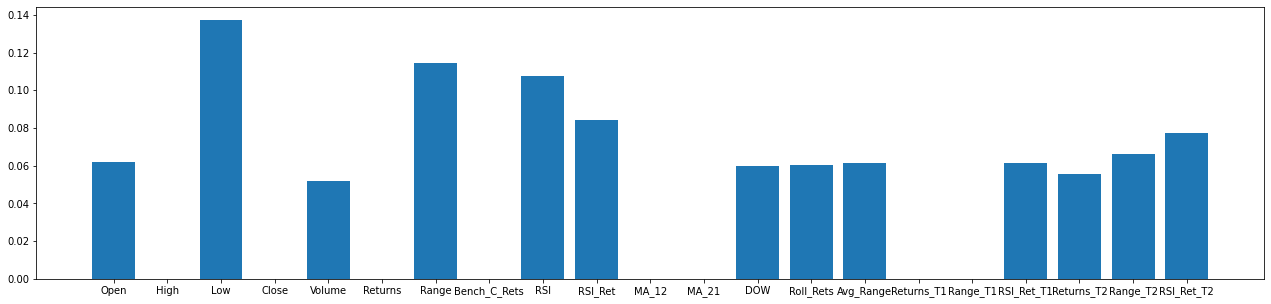

In [49]:
# plot feature importances
plt.figure(figsize=(22,5))
importance_labels = X.columns
importance_features = clf_1.feature_importances_
plt.bar(importance_labels, importance_features)
plt.show()

In [50]:
# select best features
mean_feature_importance = importance_features.mean()
i = 0 
best_feature_labels = []
best_feature_scores = []

for importance_score in importance_features:
  if importance_score > mean_feature_importance:
    best_feature_labels.append(importance_labels[i])
    best_feature_scores.append(importance_score)
  i =+ 1

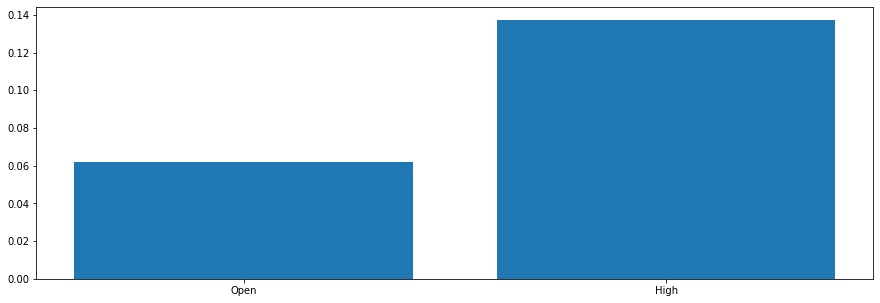

In [52]:
# plot recommended features
plt.figure(figsize=(15,5))
plt.bar(best_feature_labels, best_feature_scores)
plt.show()